<a href="https://colab.research.google.com/github/SnehaVeerakumar/SpamClassification-using-SVM/blob/main/E_mail_SpamClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CSE 4027 DATA ANALYTICS**
Under the guidance of **Dr.Senthil Murugan**, project has been developed using Support Vector Machine, a machine learning model to classify between spam and non spam texts/sms/ mails.

# **Clasification of Spam/Non spam using support vector machine (SVM)**
**Problem Description** :

> Aim of the project is to build a spam classifier that can categorise an e-mail as either “spam” or “ham” using Support Vector Machine.


**Support Vector Machine**

> SVM builds a classifier by searching for a separating hyperplane (optimal hyperplane) which is optimal and maximises the margin that separates the categories (in our case spam and ham). Thus, SVM has the advantage of robustness in general and effectiveness when the number of dimensions is greater than the number of samples.

**Introduction**
> A dataset consisting of 5728 e-mails has been pre-processed to get the frequencies i.e., number of occurences of each word. After pre-processing, words have been classified into spam and non spam using text mining packages. Top four kernels of SVM model has been tested for accuracy and the best kernel has been chosen for prediction. Once the text mining process is terminated, fit the SVM model with best kernel to predict whether an e-mail is spam or ham.

**Dataset Description**

> 1.   e-mails.csv contains the subject and body of the email.
2.   names.csv contains the words with high frequency.
3. data.csv contains the frequencies of each word.

**Index**

> 1.   Introduction
2.   SVM Kernel Functions
3. Text Mining for E-mail dataset
4. E-mail spam classification using SVM
5. Results and Analysis




# **Introduction**

In [ ]:
# Installation of all the required packages for the project
# Syntax : install.packages("package_name")

install.packages("datasets")
install.packages("tm")
install.packages("SnowballC")
install.packages("wordcloud")
install.packages("e1071")
install.packages("tidyverse")
install.packages("mlbench")
install.packages("kableExtra")
install.packages("gridExtra")
install.packages("caTools")
install.packages("mlr")
install.packages("fdm2id")
install.packages("caret")
install.packages("doMC")
install.packages("kernlab")

In [ ]:
# Load packages which have been installed in previous cell
# Syntax : library(package_name)

library(datasets)
library(tm)
library(SnowballC)
library(wordcloud)
library(e1071)
library(tidyverse)
library(mlbench)
library(kableExtra)
library(gridExtra)
library(caTools)
library(mlr)
library(fdm2id)
library(caret)
library(doMC)
library(kernlab)

In [ ]:
# importing necessary datasets (File format : CSV)
# Syntax : variable <- read.csv("fileName.csv")

emails = read.csv('emails.csv', stringsAsFactors = FALSE)
dataset <- read.csv("data.csv",header=FALSE,sep=";")
names <- read.csv("names.csv",header=FALSE,sep=";")

# **SVM Kernel functions**

In [ ]:
# Four different datasets has been defined with different boundaries between classes

# Dataset-1 : Iris
data(iris)
iris <- iris %>% rename("X" = "Sepal.Length", "Y" = "Sepal.Width") %>% 
                   mutate(Class = as.factor(ifelse(Species == "setosa", "Class 1", "Class 2")))

# Dataset-2 : twomoons
two_moons <- data.twomoons(sigma = 0.1, graph = FALSE)

#Dataset-3 : target
target <- data.target2(initn = 600, graph = FALSE)

# Dataset-4 : spirals
spirals <- mlbench.spirals(n=600, cycles=2, sd=0.05)
spirals <- data.frame(X=spirals$x[,1], Y=spirals$x[,2], Class=spirals$classes)
levels(spirals$Class) <- c("Class 1", "Class 2")

In [ ]:
# Top four types of SVM Kernels : Linear, Poly, Radial and Sigmoid
# Obtaining the accuracy with above four datasets to choose the better kernel for proceeding in project

accuracy <- sapply(list(iris, two_moons, target, spirals), function(df){
  
  models <- lapply(list("linear", "poly", "radial", "sigmoid"), function(meth){
    return(svm(Class ~ X + Y, df, kernel=meth, prob=TRUE))
  })
  
  names(models) <- c("linear", "poly", "radial", "sigmoid")
  
  accuracy <- sapply(models, function(x) sum(x$fitted == df$Class)/nrow(df))
  names(accuracy) <- names(models)
  return(accuracy)
  
})

colnames(accuracy) <- c("iris", "moons", "target", "spirals")

accuracy <- data.frame(accuracy)

print(accuracy)

             iris moons    target   spirals
linear  0.9933333 0.930 0.8211921 0.5000000
poly    0.9866667 0.945 0.8211921 0.5133333
radial  0.9933333 1.000 1.0000000 0.5700000
sigmoid 0.9800000 0.825 0.7450331 0.4000000


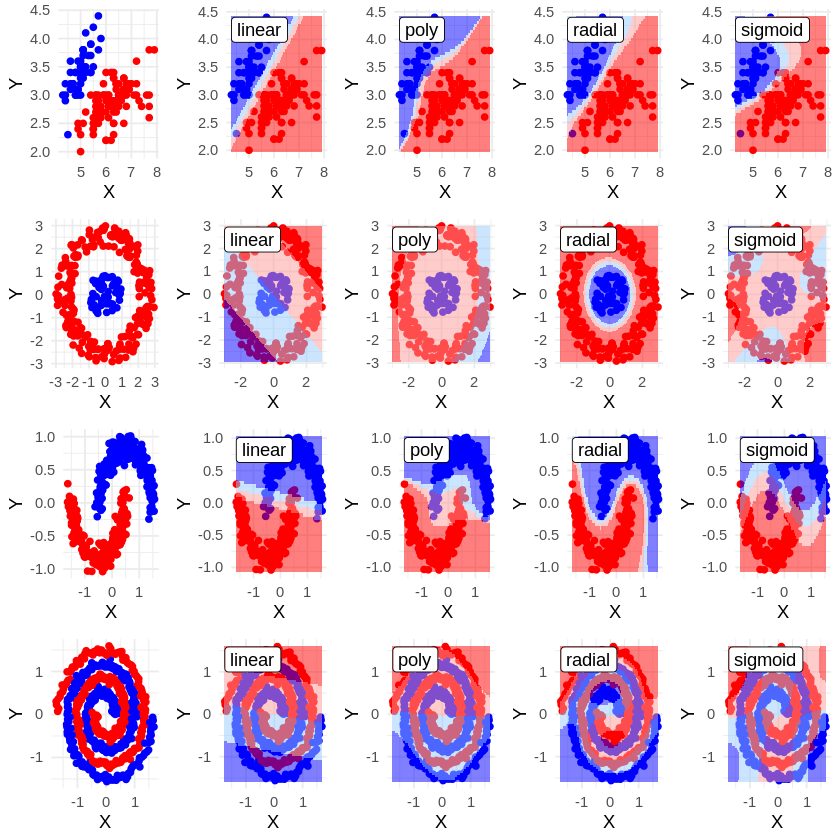

In [ ]:
# DATA VISUALIZATION
# Plotting the prediction of each kernel with probability of classification for each point in the graph. 
# Bold colors in background correspond to high probabilities of classification (above 0.75). 

kernel_plot <- function(df){
    grid <- expand.grid(X=seq(min(df$X), max(df$X), 0.05), Y=seq(min(df$Y), max(df$Y), 0.05))
    
    svm <- lapply(list("linear", "poly", "radial", "sigmoid"), function(x){
      return(svm(Class ~ X + Y, df, kernel=x, prob=TRUE))
    })
    names(svm) <- c("linear", "poly", "radial", "sigmoid")
    
    #grid values
    pred <- sapply(svm, function(x){
      pr <- attr(predict(x, grid, probability=TRUE), "probabilities")
      return(pr[ , which(attr(pr, "dimnames")[[2]] == "Class 1")])
    }) 
    pred_cut <- apply(pred, 2, function(x) cut(x, breaks = 4))
    grid <- cbind(grid, pred_cut)
    
    plot_base <- ggplot(df) + 
      geom_point(aes(X, Y, col=Class), show.legend = FALSE) +
      scale_color_manual(values=c("#0000FF", "#FF0000")) +
      theme_minimal()
    
    plots <- lapply(names(svm), function(x){
      plot_base +
        geom_tile(data=grid, aes(X, Y, fill=grid[, x]), show.legend = FALSE, alpha=0.5) + 
        scale_fill_manual(values=c("#FF0000", "#FF9999", "#99CCFF", "#0000FF")) + 
        annotate(geom="label", x=min(grid$X), y=max(grid$Y), label=x, hjust="inward", vjust="inward")
    })
       
    outcome <- list(plot_base)
    outcome <- c(outcome, plots)
    
    names(outcome) <- c("base", "linear", "poly", "radial", "sigmoid")
    return(outcome)
}

# Plot the graph for Kernel functions with respect to the each dataset
grid.arrange(grobs = c(kernel_plot(iris), kernel_plot(target), 
                       kernel_plot(two_moons), kernel_plot(spirals)), ncol=5)

# **Text Mining for E-Mail dataset**

In [ ]:
# Internal structure of E-mail dataset
# Syntax : str(datasetName, …)

str(emails)

'data.frame':	5728 obs. of  2 variables:
 $ text: chr  "Subject: naturally irresistible your corporate identity  lt is really hard to recollect a company : the  market"| __truncated__ "Subject: the stock trading gunslinger  fanny is merrill but muzo not colza attainder and penultimate like esmar"| __truncated__ "Subject: unbelievable new homes made easy  im wanting to show you this  homeowner  you have been pre - approved"| __truncated__ "Subject: 4 color printing special  request additional information now ! click here  click here for a printable "| __truncated__ ...
 $ spam: int  1 1 1 1 1 1 1 1 1 1 ...


In [ ]:
# Categorical representation of data with variable name
# Syntax : table(ObjectToBeCoverted)

table(emails$spam) # 0 represents ham


   0    1 
4360 1368 

In [ ]:
# Build a new corpus variable called corpus
corpus = VCorpus(VectorSource(emails$text))

# convert the text to lowercase
corpus = tm_map(corpus, content_transformer(tolower))
corpus = tm_map(corpus, PlainTextDocument)

# remove all punctuation from the corpus
corpus = tm_map(corpus, removePunctuation)
# remove all English stopwords from the corpus
corpus = tm_map(corpus, removeWords, stopwords("en"))

# stem the words in the corpus
corpus = tm_map(corpus, stemDocument)

In [ ]:
# Build a Document Term Matrix from the corpus
# rows correspond to emails and columns correspond to words.

dtm = DocumentTermMatrix(corpus)
dtm

<<DocumentTermMatrix (documents: 5728, terms: 28687)>>
Non-/sparse entries: 481719/163837417
Sparsity           : 100%
Maximal term length: 24
Weighting          : term frequency (tf)

In [ ]:
# Removal of sparse terms (word that don't appear often)

spdtm = removeSparseTerms(dtm, 0.95)
spdtm

<<DocumentTermMatrix (documents: 5728, terms: 330)>>
Non-/sparse entries: 213551/1676689
Sparsity           : 89%
Maximal term length: 10
Weighting          : term frequency (tf)

In [ ]:
# Convert spdtm to a data frame
emailsSparse = as.data.frame(as.matrix(spdtm))

# make variable names of emailsSparse valid
colnames(emailsSparse) = make.names(colnames(emailsSparse))

In [ ]:
# word stem that shows up most frequently across all the emails

tail(sort(colSums(emailsSparse)))

hou    will    vinc subject     ect   enron 
   5577    8252    8532   10202   11427   13388

In [ ]:
emailsSparse$spam = emails$spam

In [ ]:
# Word Frequencies of HAM words in ascending order

tail(sort(colSums(subset(emailsSparse, spam == 0))))

hou    will    vinc subject     ect   enron 
   5569    6802    8531    8625   11417   13388

In [ ]:
# Word Frequencies of SPAM words in ascending order

tail(sort(colSums(subset(emailsSparse, spam == 1))))

mail     com compani    spam    will subject 
    917     999    1065    1368    1450    1577

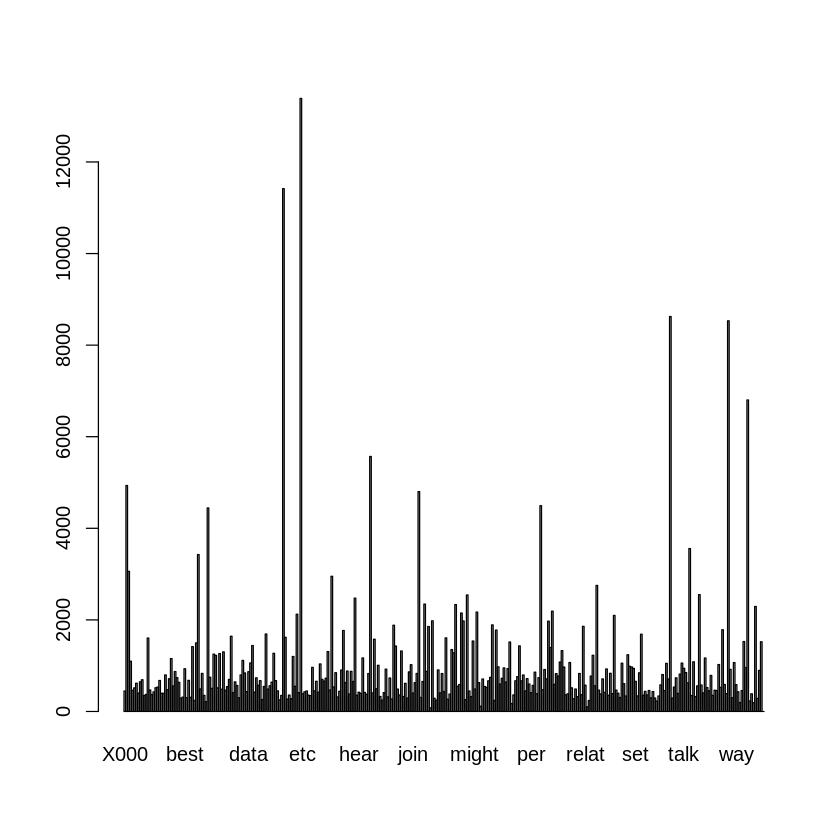

In [ ]:
# Bar plot of words against word frequency
# Syntax : barplot(Vector,xlab,ylab,main, names.arg,col)

barplot(colSums(subset(emailsSparse, spam == 0)))

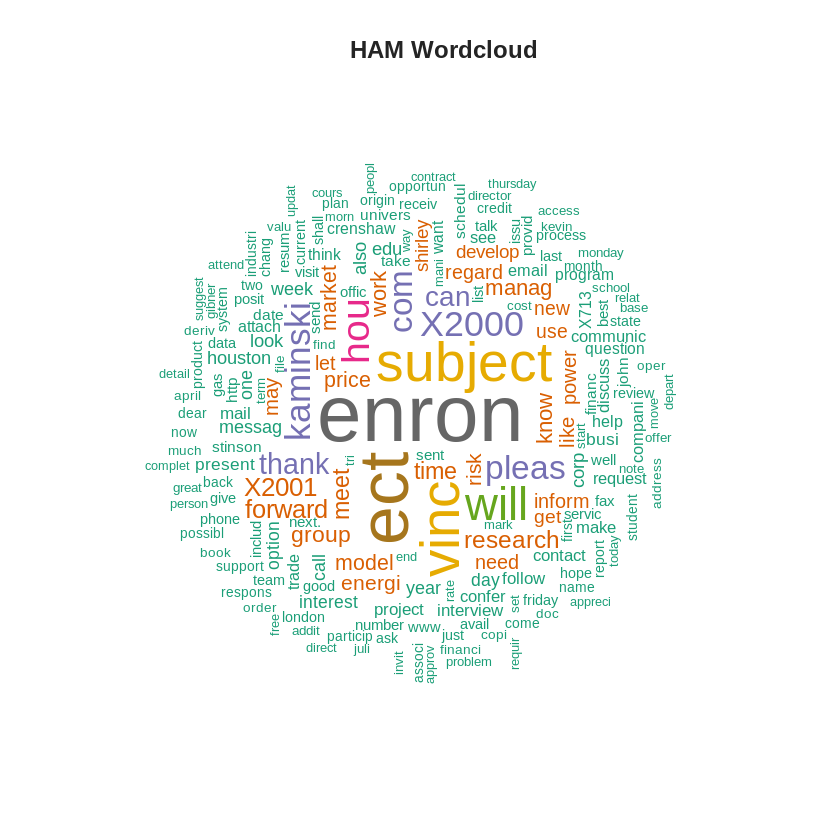

In [ ]:
# HAM Word cloud for a clear idea about word frequency

set.seed(1234) # for reproducibility 
wordcloud(words = colnames(emailsSparse), freq = colSums(subset(emailsSparse, spam == 0)), min.freq = 1,        
          max.words=200, random.order=FALSE, rot.per=0.35,  colors=brewer.pal(8, "Dark2"))
title("HAM Wordcloud", col.main = "grey14")

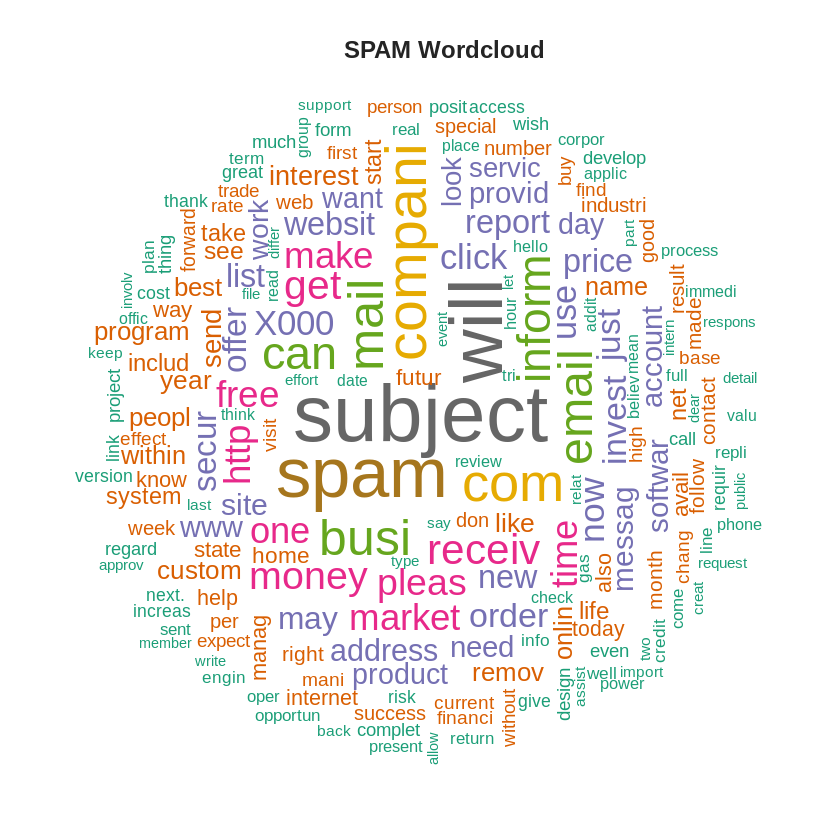

In [ ]:
# SPAM word cloud

set.seed(1234) # for reproducibility
wordcloud(words = colnames(emailsSparse), freq = colSums(subset(emailsSparse, spam == 1)), min.freq = 1,        
          max.words=200, random.order=FALSE, rot.per=0.35,  colors=brewer.pal(8, "Dark2"))
title("SPAM Wordcloud", col.main = "grey14")

# **Spam classification using SVM**

In [ ]:
str(names)

'data.frame':	58 obs. of  1 variable:
 $ V1: chr  "word_freq_make" "word_freq_address" "word_freq_all" "word_freq_3d" ...


In [ ]:
str(dataset)

'data.frame':	4601 obs. of  58 variables:
 $ V1 : num  0 0.21 0.06 0 0 0 0 0 0.15 0.06 ...
 $ V2 : num  0.64 0.28 0 0 0 0 0 0 0 0.12 ...
 $ V3 : num  0.64 0.5 0.71 0 0 0 0 0 0.46 0.77 ...
 $ V4 : num  0 0 0 0 0 0 0 0 0 0 ...
 $ V5 : num  0.32 0.14 1.23 0.63 0.63 1.85 1.92 1.88 0.61 0.19 ...
 $ V6 : num  0 0.28 0.19 0 0 0 0 0 0 0.32 ...
 $ V7 : num  0 0.21 0.19 0.31 0.31 0 0 0 0.3 0.38 ...
 $ V8 : num  0 0.07 0.12 0.63 0.63 1.85 0 1.88 0 0 ...
 $ V9 : num  0 0 0.64 0.31 0.31 0 0 0 0.92 0.06 ...
 $ V10: num  0 0.94 0.25 0.63 0.63 0 0.64 0 0.76 0 ...
 $ V11: num  0 0.21 0.38 0.31 0.31 0 0.96 0 0.76 0 ...
 $ V12: num  0.64 0.79 0.45 0.31 0.31 0 1.28 0 0.92 0.64 ...
 $ V13: num  0 0.65 0.12 0.31 0.31 0 0 0 0 0.25 ...
 $ V14: num  0 0.21 0 0 0 0 0 0 0 0 ...
 $ V15: num  0 0.14 1.75 0 0 0 0 0 0 0.12 ...
 $ V16: num  0.32 0.14 0.06 0.31 0.31 0 0.96 0 0 0 ...
 $ V17: num  0 0.07 0.06 0 0 0 0 0 0 0 ...
 $ V18: num  1.29 0.28 1.03 0 0 0 0.32 0 0.15 0.12 ...
 $ V19: num  1.93 3.47 1.36 3.18 3.18 0

In [ ]:
head(names)

,V1
,<chr>
1,word_freq_make
2,word_freq_address
3,word_freq_all
4,word_freq_3d
5,word_freq_our
6,word_freq_over


In [ ]:
head(dataset)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,⋯,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>
1,0.00,0.64,0.64,0,0.32,0.00,0.00,0.00,0.00,0.00,⋯,0.00,0.000,0,0.778,0.000,0.000,3.756,61,278,1
2,0.21,0.28,0.50,0,0.14,0.28,0.21,0.07,0.00,0.94,⋯,0.00,0.132,0,0.372,0.180,0.048,5.114,101,1028,1
3,0.06,0.00,0.71,0,1.23,0.19,0.19,0.12,0.64,0.25,⋯,0.01,0.143,0,0.276,0.184,0.010,9.821,485,2259,1
4,0.00,0.00,0.00,0,0.63,0.00,0.31,0.63,0.31,0.63,⋯,0.00,0.137,0,0.137,0.000,0.000,3.537,40,191,1
5,0.00,0.00,0.00,0,0.63,0.00,0.31,0.63,0.31,0.63,⋯,0.00,0.135,0,0.135,0.000,0.000,3.537,40,191,1
6,0.00,0.00,0.00,0,1.85,0.00,0.00,1.85,0.00,0.00,⋯,0.00,0.223,0,0.000,0.000,0.000,3.000,15,54,1


In [ ]:
# Set the "names" as column names of "dataset" dataframe

names(dataset) <- sapply((1:nrow(names)),function(i) toString(names[i,1]))

In [ ]:
# Verify if the column names has been added to dataset
# View Column names of a dataframe
# Syntax : colnames(dataframe_Name)

colnames(dataset)

[1] "word_freq_make"             "word_freq_address"         
 [3] "word_freq_all"              "word_freq_3d"              
 [5] "word_freq_our"              "word_freq_over"            
 [7] "word_freq_remove"           "word_freq_internet"        
 [9] "word_freq_order"            "word_freq_mail"            
[11] "word_freq_receive"          "word_freq_will"            
[13] "word_freq_people"           "word_freq_report"          
[15] "word_freq_addresses"        "word_freq_free"            
[17] "word_freq_business"         "word_freq_email"           
[19] "word_freq_you"              "word_freq_credit"          
[21] "word_freq_your"             "word_freq_font"            
[23] "word_freq_000"              "word_freq_money"           
[25] "word_freq_hp"               "word_freq_hpl"             
[27] "word_freq_george"           "word_freq_650"             
[29] "word_freq_lab"              "word_freq_labs"            
[31] "word_freq_telnet"           "word_freq_857"             
[33] "word_freq_data"             "word_freq_415"             
[35] "word_freq_85"               "word_freq_technology"      
[37] "word_freq_1999"             "word_freq_parts"           
[39] "word_freq_pm"               "word_freq_direct"          
[41] "word_freq_cs"               "word_freq_meeting"         
[43] "word_freq_original"         "word_freq_project"         
[45] "word_freq_re"               "word_freq_edu"             
[47] "word_freq_table"            "word_freq_conference"      
[49] "char_freq_;"                "char_freq_("               
[51] "char_freq_["                "char_freq_!"               
[53] "char_freq_$"                "char_freq_#"               
[55] "capital_run_length_average" "capital_run_length_longest"
[57] "capital_run_length_total"   "y"

In [ ]:
# Another way to verify is by view first few rows of dataframe

head(dataset)

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,⋯,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,y
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>
1,0.00,0.64,0.64,0,0.32,0.00,0.00,0.00,0.00,0.00,⋯,0.00,0.000,0,0.778,0.000,0.000,3.756,61,278,1
2,0.21,0.28,0.50,0,0.14,0.28,0.21,0.07,0.00,0.94,⋯,0.00,0.132,0,0.372,0.180,0.048,5.114,101,1028,1
3,0.06,0.00,0.71,0,1.23,0.19,0.19,0.12,0.64,0.25,⋯,0.01,0.143,0,0.276,0.184,0.010,9.821,485,2259,1
4,0.00,0.00,0.00,0,0.63,0.00,0.31,0.63,0.31,0.63,⋯,0.00,0.137,0,0.137,0.000,0.000,3.537,40,191,1
5,0.00,0.00,0.00,0,0.63,0.00,0.31,0.63,0.31,0.63,⋯,0.00,0.135,0,0.135,0.000,0.000,3.537,40,191,1
6,0.00,0.00,0.00,0,1.85,0.00,0.00,1.85,0.00,0.00,⋯,0.00,0.223,0,0.000,0.000,0.000,3.000,15,54,1


In [ ]:
# View the class of dataframe.
# If dataframe is not in factor class, convert to factor class.

class(dataset$y)

[1] "integer"

In [ ]:
# make column y a factor variable for binary classification (spam or non-spam)

dataset$y <- as.factor(dataset$y)
class(dataset$y)

[1] "factor"

In [ ]:
# Get a sample of 1000 rows from 4000 rows
sample <- dataset[sample(nrow(dataset), 1000),]


#Split the data in dataTrain and dataTest
trainIndex <- createDataPartition(sample$y, p = .8, list = FALSE, times = 1)
dataTrain <- sample[ trainIndex,]
dataTest  <- sample[-trainIndex,]

#set up multicore environment for faster implementation
registerDoMC(cores=5)

In [ ]:
# Dimension of train dataframe using dim()
# Syntax : dim(DataFrame)
# Output format : Rows . Columns

dim(dataTrain)

[1] 800  58

In [ ]:
# Dimension of test dataframe using dim()
# Syntax : dim(DataFrame)

dim(dataTest)

[1] 200  58

In [ ]:
# Finding the right tuning parameters for our SVM.
# Sigest function from the kernlab package to find the best sigma value and create a TuneGrid with that.

sigDist <- sigest(y ~ ., data = dataTrain, frac = 1)

# Creating a grid of two tuning parameters 
# ".sigma" comes from the previous R command line. 
# Find best value of .C : Larger the value of C, the optimization will choose a smaller-margin hyperplane.

svmTuneGrid <- data.frame(.sigma = sigDist[1], .C = 2^(-2:7))
svmTuneGrid

Warning message in data.frame(.sigma = sigDist[1], .C = 2^(-2:7)):
“row names were found from a short variable and have been discarded”


.sigma,.C
<dbl>,<dbl>
0.004136969,0.25
0.004136969,0.50
0.004136969,1.00
0.004136969,2.00
0.004136969,4.00
0.004136969,8.00
0.004136969,16.00
0.004136969,32.00
0.004136969,64.00


In [ ]:
# Train the SVM with the train() function of the caret package.
# Radial Kernel of SVM model has been used.

x<- train(y ~ .,
                 data = dataTrain,
                 method = "svmRadial",
                 preProc = c("center", "scale"),
                tuneGrid = svmTuneGrid,
                 trControl = trainControl(method = "repeatedcv", repeats = 5))

In [ ]:
#EVALUATION

# For the evaluation, we use predict() function of the caret package.
# Exclude the column of dataframe which contents the label if the email is spam or ham.

pred <- predict(x,dataTest[,1:57])

# compare the results based on our model with the actual results in the last column of the "dataTest" dataframe.

confuction_matrix <- confusionMatrix(pred,dataTest$y)
confuction_matrix

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 115   7
         1   7  71
                                          
               Accuracy : 0.93            
                 95% CI : (0.8853, 0.9612)
    No Information Rate : 0.61            
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.8529          
                                          
 Mcnemar's Test P-Value : 1               
                                          
            Sensitivity : 0.9426          
            Specificity : 0.9103          
         Pos Pred Value : 0.9426          
         Neg Pred Value : 0.9103          
             Prevalence : 0.6100          
         Detection Rate : 0.5750          
   Detection Prevalence : 0.6100          
      Balanced Accuracy : 0.9264          
                                          
       'Positive' Class : 0               
                              

# **Results And Analysis**

In [ ]:
# Accuracy of 4 kernels of SVM with respect to 4 datasets
accuracy

,iris,moons,target,spirals
,<dbl>,<dbl>,<dbl>,<dbl>
linear,0.9933333,0.930,0.8211921,0.5000000
poly,0.9866667,0.945,0.8211921,0.5133333
radial,0.9933333,1.000,1.0000000,0.5700000
sigmoid,0.9800000,0.825,0.7450331,0.4000000


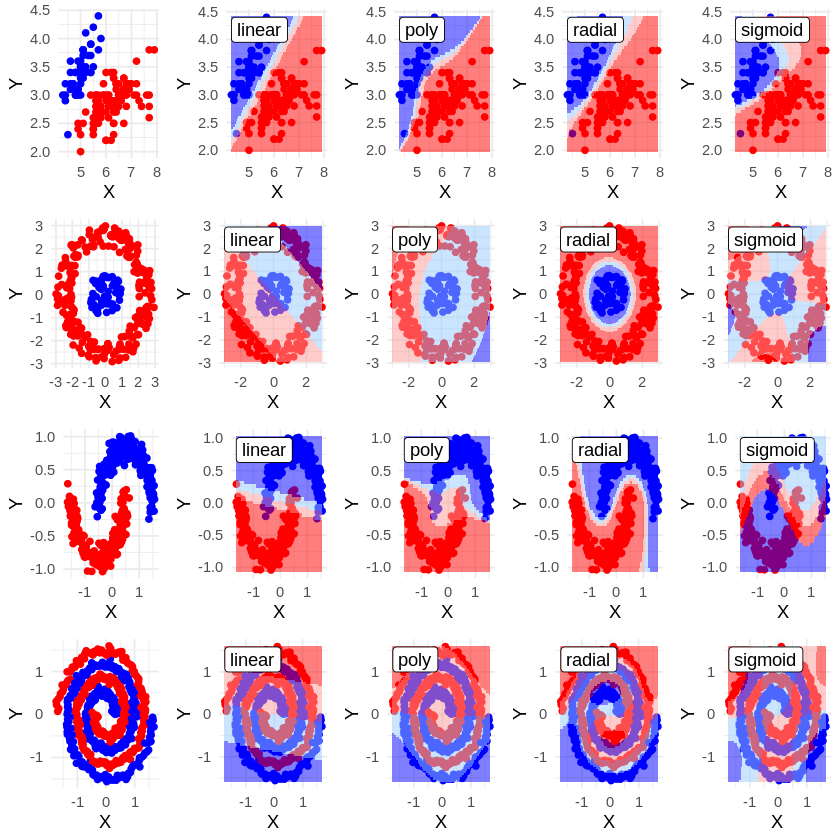

In [ ]:
# Visualizing the performance of each kernel
grid.arrange(grobs = c(kernel_plot(iris), kernel_plot(target), kernel_plot(two_moons), kernel_plot(spirals)), ncol=5)

**Conclusion** : Accuracy of Radial kernel is better than other three.

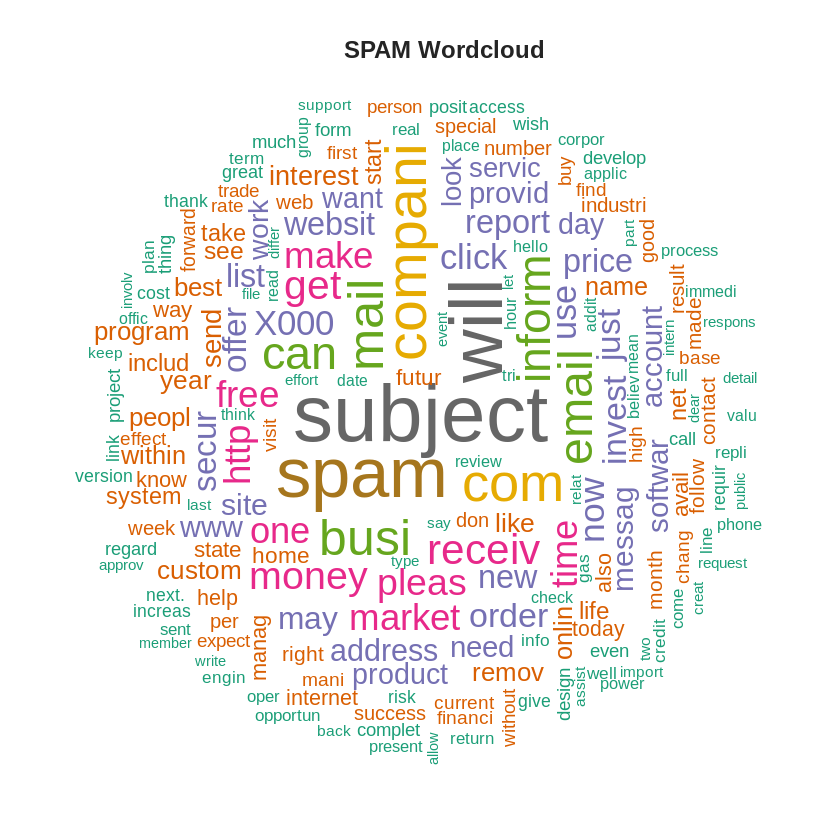

In [ ]:
# SPAM word cloud

set.seed(1234) # for reproducibility
wordcloud(words = colnames(emailsSparse), freq = colSums(subset(emailsSparse, spam == 1)), min.freq = 1,        
          max.words=200, random.order=FALSE, rot.per=0.35,  colors=brewer.pal(8, "Dark2"))
title("SPAM Wordcloud", col.main = "grey14")

In [ ]:
# .C value to choose the hyperplane
svmTuneGrid

.sigma,.C
<dbl>,<dbl>
0.004136969,0.25
0.004136969,0.50
0.004136969,1.00
0.004136969,2.00
0.004136969,4.00
0.004136969,8.00
0.004136969,16.00
0.004136969,32.00
0.004136969,64.00


In [ ]:
confuction_matrix

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 115   7
         1   7  71
                                          
               Accuracy : 0.93            
                 95% CI : (0.8853, 0.9612)
    No Information Rate : 0.61            
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.8529          
                                          
 Mcnemar's Test P-Value : 1               
                                          
            Sensitivity : 0.9426          
            Specificity : 0.9103          
         Pos Pred Value : 0.9426          
         Neg Pred Value : 0.9103          
             Prevalence : 0.6100          
         Detection Rate : 0.5750          
   Detection Prevalence : 0.6100          
      Balanced Accuracy : 0.9264          
                                          
       'Positive' Class : 0               
                              

**Conclusion :** Trained SVM model gives the prediction of spam e-mail with the accuracy of ~90%